# Trabajo 1: Clasificación con Naive Bayes

**Mediante este trabajo se pretende que pongas en práctica la creación de modelos basados en el clasificador Naive Bayes. El objetivo es que comprendas de forma práctica con un problema determinado los pasos que hay que realizar para construir un clasificador Naive Bayes que infiera la clase más probable de dos eventos.**

## Importación de librerías

En primer lugar, se importan las librerías necesarias para la realización de este trabajo.  
En este caso, se utilizarán las siguientes librerías:
* MatplotLib: Para la generación de gráficas (Curvas ROC, validación de los datos, etc)
* Numpy: Para cálculos con datos y obtención de la matriz de confusión
* Pandas: Para el procesamiento de la información
* Scikit-learn: Para la aplicación de técnicas de machine learning


In [252]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

## Carga de la información

A continuación, se procede a cargar un set de datos. En este caso se utiliza un set de datos de prueba, *load_breast_cancer* , el cual es provisto por scikit learn.  
De este se sacan sus dos componentes:  
* _X = El vector de características
* _y = La variable target o clase

In [265]:
# Se hace una lectura del csv y se le añaden los nombres de las columnas

columns = ["Class Name", "handicapped-infants", "water-project-cost-sharing", 
           "adoption-of-the-budget-resolution", "physician-fee-freeze", 
           "el-salvador-aid", "religious-groups-in-schools", "anti-satellite-test-ban", 
           "aid-to-nicaraguan-contras", "mx-missile", "immigration", "synfuels-corporation-cutback",
           "education-spending", "superfund-right-to-sue", "crime", "duty-free-exports",
           "export-administration-act-south-africa"]
data = pd.read_csv("data/house-votes-84.data", delimiter=",", names=columns)


df = pd.DataFrame(data, columns=columns)
df = df.replace("y", 1)
df = df.replace("n", 0)
df = df.replace("?", np.nan)

# Se extraen de este dataframe las features
_X = df.loc[:, df.columns != 'Class Name']

# Se crea un vector con los targets
_y = df["Class Name"]

print("El número de características es de: "+ str(_X.shape[1]))
df.head(5)

El número de características es de: 16


,Class Name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


## Seleccion de Modelo Naive Bayes

Existen tres tipos de modelos Naive Bayes implementados en Scikit Learn:
* Gaussian Naive Bayes:
* Multinomial Naive Bayes: 
* Complement Naive Bayes: 
* Bernoulli Naive Bayes: 

A continuación se harán pruebas de los distintos modelos para obtener el modelo con mayor precisión. 
  
Además, se harán varios tipos de prueba dado que en las variables de entrada hay ciertos datos que no existen, por lo que se plantean varias soluciones a probar para cada uno de estos modelos:
* Uso de la media: Se utiliza la media de cada una de las columnas para asignar un valor a los datos faltantes.
* Uso de la mediana: Se utiliza la mediana de cada una de las columnas para asignar un valor a los datos faltantes.
* Uso de una constante: Se utiliza otra constante para asignar otra "categoria" a esa variable
Para todo esto se hará uso de la librería **SimpleImputer**, la cual permite seguir estas estrategias.

Para ello, se crea una función que a partir de un modelo, un vector de características, las variables *target* y un número de folds, devuelve un *score* medio e imprime además la matriz de confusión asociada.

In [266]:
def score_and_confussion_matrix(nb, X, y, cv):
    """
    Esta función imprime por pantalla el valor score medio
    y la matriz de confusión generada mediante un cross-validation
    de un modelo concreto.
    Return: Score medio
    """
    scores = cross_val_score(nb, X, y, cv=cv)
    y_pred = cross_val_predict(nb, X, y, cv=cv)
    confussion_matrix = pd.crosstab(y, y_pred)
    
    print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("\n")
    print(confussion_matrix.head())
    return scores.mean()

Se generan distintos vectores de característica en función de la forma en la que se decide "rellenar" los valores *NaN. Con esto, se aplica la función anterior con todos los modelos planteados anteriormente.

In [267]:
X = _X
y = _y
# Se genera un vector de características con los valores NaN sustitidos por las medias
imputer = SimpleImputer(missing_values=np.NAN, strategy='mean')
X_mean = imputer.fit_transform(X)
# Se genera un vector de características con los valores NaN sustitidos por las medianas
imputer = SimpleImputer(missing_values=np.NAN, strategy='median')
X_median = imputer.fit_transform(X)
# Se genera un vector de características con los valores NaN sustitidos por una constante
imputer = SimpleImputer(missing_values=np.NAN, strategy='constant')
X_constant = imputer.fit_transform(X)

# Se crea un array con todos los vectores anteriores para iterar sobre ellos
X_all = [X_mean, X_median, X_constant]
fillnan_type = ["Mean", "Median", "Constant"]
i=0

# Se crean una variables para identificar el mejor modelo
best_model = ""
best_accuracy = 0
best_fillna_type = ""

"""
 Se itera sobre los distintos modelos llamando a la función
creada anteriormente para obtener los distintos scores y
obtener el modelo con mayor score
"""
for X in X_all:
    print(fillnan_type[i])
    print("---------------------------------------")
    print("Using Gaussian NB")
    print("......................")
    nb = GaussianNB()
    score = score_and_confussion_matrix(nb, X, y, 10)
    if score > best_accuracy:
        best_accuracy = score
        best_fillna_type = fillnan_type[i]
        best_model = "GaussianNB"
        
    print("\n")
    print("Using Bernoulli NB")
    print("......................")
    nb = BernoulliNB()
    score = score_and_confussion_matrix(nb, X, y, 10)
    if score > best_accuracy:
        best_accuracy = score
        best_fillna_type = fillnan_type[i]
        best_model = "BernoulliNB"

    print("\n")
    print("Using Multinomial NB")
    print("......................")
    nb = MultinomialNB()
    score = score_and_confussion_matrix(nb, X, y, 10)
    if score > best_accuracy:
        best_accuracy = score
        best_fillna_type = fillnan_type[i]
        best_model = "MultinomialNB"

    print("\n")
    print("Using Complement NB")
    print("......................")
    nb = ComplementNB()
    score_and_confussion_matrix(nb, X, y, 10)
    print("\n")
    print("\n")
    i+= 1

Mean
---------------------------------------
Using Gaussian NB
......................
Accuracy: 0.940 (+/- 0.10)


col_0       democrat  republican
Class Name                      
democrat         254          13
republican        13         155


Using Bernoulli NB
......................
Accuracy: 0.898 (+/- 0.15)


col_0       democrat  republican
Class Name                      
democrat         237          30
republican        14         154


Using Multinomial NB
......................
Accuracy: 0.898 (+/- 0.14)


col_0       democrat  republican
Class Name                      
democrat         238          29
republican        15         153


Using Complement NB
......................
Accuracy: 0.905 (+/- 0.13)


col_0       democrat  republican
Class Name                      
democrat         237          30
republican        11         157




Median
---------------------------------------
Using Gaussian NB
......................
Accuracy: 0.924 (+/- 0.14)


col_0       de

A continuación, a partir de las variables creadas anteriormente, se imprime el modelo seleccionado con una mejor precisión y el tipo de "relleno" de *NaN* seleccionado

In [268]:
print("--------Summary--------")
print("Best FillNaN: " + best_fillna_type)
print("Best Model: " + best_model)
print("Score: " + str(round(best_accuracy, 3)))

--------Summary--------
Best FillNaN: Mean
Best Model: GaussianNB
Score: 0.94


El modelo seleccionado es un **GaussianNB**, rellenando los *NaN* mediante el uso de **la media**, teniendo un esto una **precisión del 94%**.

## Reducción de la dimensionalidad

Los modelos anteriores han sido creados usando todas las características del dataset.En ocasiones, pueden existir correlaciones entre distintas variables lo que puede dar lugar a peores modelos.  
  
Debido a esto, se decide utilizar un algoritmo de **eliminación de características**, en este caso se ha usado el **RFE**.  
Mediante el uso de un **Cross Validation**, se comprueba cuál es el **numero de características es el más óptimo** para este modelo.  

Para ello, se muestra el score del modelo aplicando el distinto número de características en una gráfica. El punto más alto, determina el mejor *score* asociado a un número de características en particular.

El número óptimo de características es : 1


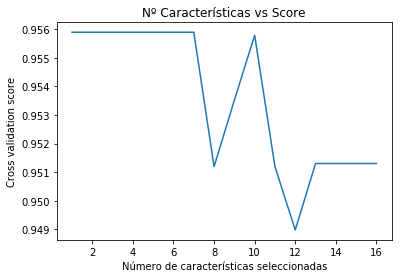

In [269]:
X = _X
y = _y

imputer = SimpleImputer(missing_values=np.NAN, strategy='constant')
X = imputer.fit_transform(X)
# Se crea un RFE (Recursive feature elimination) con un Cross Validation (de 10 Folds)
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
selector = rfecv.fit(X, y)

# Mediante el método n_features_ se obtiene el número de características
print("El número óptimo de características es : %d" % rfecv.n_features_)


#Se crea un plot donde se puede observar el score en función de estas características
plt.figure()
plt.title("Nº Características vs Score")
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

El **número de características** elegidas es **1** dado que tiene un mayor *score*  

A continuación se seleccionan las columnas elegidas.  
Para ello, se seleccionan las variables cuyo parámetro *.support_* este seteado a *True*. Estas son las seleccionadas para el modelo.  
Con todo ello, se ejecuta la función creada anteriormente para identificar el score medio y la matriz de confusión asociada

In [270]:
# Se obtienen los índices para cuando la columna ha sido elegida (True)
index_arr = np.where(selector.support_==True)
# Se obtienen los nombres (valores) de las columnas asociados a esos índices
features = np.take(_X.columns.values.tolist(), index_arr)
print("Columnas seleccionadas para el modelo: " + str(features))
print("\n")
imputer = SimpleImputer(missing_values=np.NAN, strategy='constant')
X = imputer.fit_transform(_X[features[0]])
nb = GaussianNB()
score = score_and_confussion_matrix(nb, X, y, 10)

Columnas seleccionadas para el modelo: [['physician-fee-freeze']]


Accuracy: 0.956 (+/- 0.10)


col_0       democrat  republican
Class Name                      
democrat         253          14
republican         5         163


Mediante un modelo **GaussianNB**, rellenando los *NaN* mediante el uso de **la media** y usando únicamente **1 característica**, se consigue una **precisión del 95.6%**, mejorando la precisión obtenida con el uso de todas las características del dataset.  
Esto además de implicar una **mejora en la precisión del modelo**, también implica una **mejora de la eficiencia** y velocidad con el que se genera éste al hacer uso de un menor número de características para realizar la predicción.

Además, se obtiene la **matriz de confusión** para identificar las distintas métricas a evaluar: 

Text(0.5, 0, 'False Positive Rate')

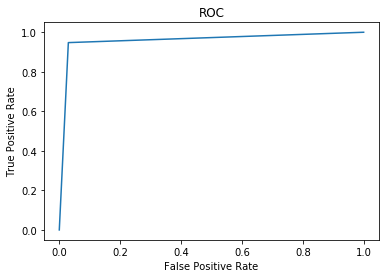

In [271]:
imputer = SimpleImputer(missing_values=np.NAN, strategy='constant')
X = imputer.fit_transform(_X[features[0]])
nb = GaussianNB()
y_pred = cross_val_predict(nb, X, y, cv=10)
y_pred = np.where(y_pred=="democrat", 1, 0)
y = np.where(y=="democrat", 1, 0)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
 # Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')